# Plot average key rank against $p$-value

In [150]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from os import path

from matplotlib.patheffects import withStroke
from matplotlib.pyplot import text, locator_params
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, AutoLocator, FixedLocator

from src.tools.plotter import store_sns, init_plots
from src.trace_set.database import Database
from src.trace_set.pollution import PollutionType

init_plots()

In [151]:
SCA_PALETTE = sns.light_palette(sns.color_palette()[2], n_colors=5)
DLLA_PALETTE = sns.light_palette(sns.color_palette()[0], n_colors=5)

In [152]:
methods = {
    "sca_hw": ("Profiled SCA ($\overline{kr}$)", SCA_PALETTE[3], "-"),
    "dlla9": ("DL-LA 9 class ($p$)", DLLA_PALETTE[3], "-"),
    "dlla2": ("Wegener DL-LA ($p$)", DLLA_PALETTE[2], "--"),
}

In [ ]:
THRESHOLD_COLOR = "#FF000080"
Y_TICKS = 5

In [ ]:
def fetch_results(db: Database, pollution: PollutionType, num_traces: str, dir_name = ""):
    suffix = ""
    if num_traces is not None:
        suffix = f"_{num_traces}"
    file_name = path.join(dir_name, f"results_{db.name}{suffix}.csv")

    df = pd.read_csv(file_name, sep=";")
    df = df[df.pollution == pollution.name].drop(columns=[df.pollution.name])

    gdf = df.groupby(df.method)

    return gdf, df

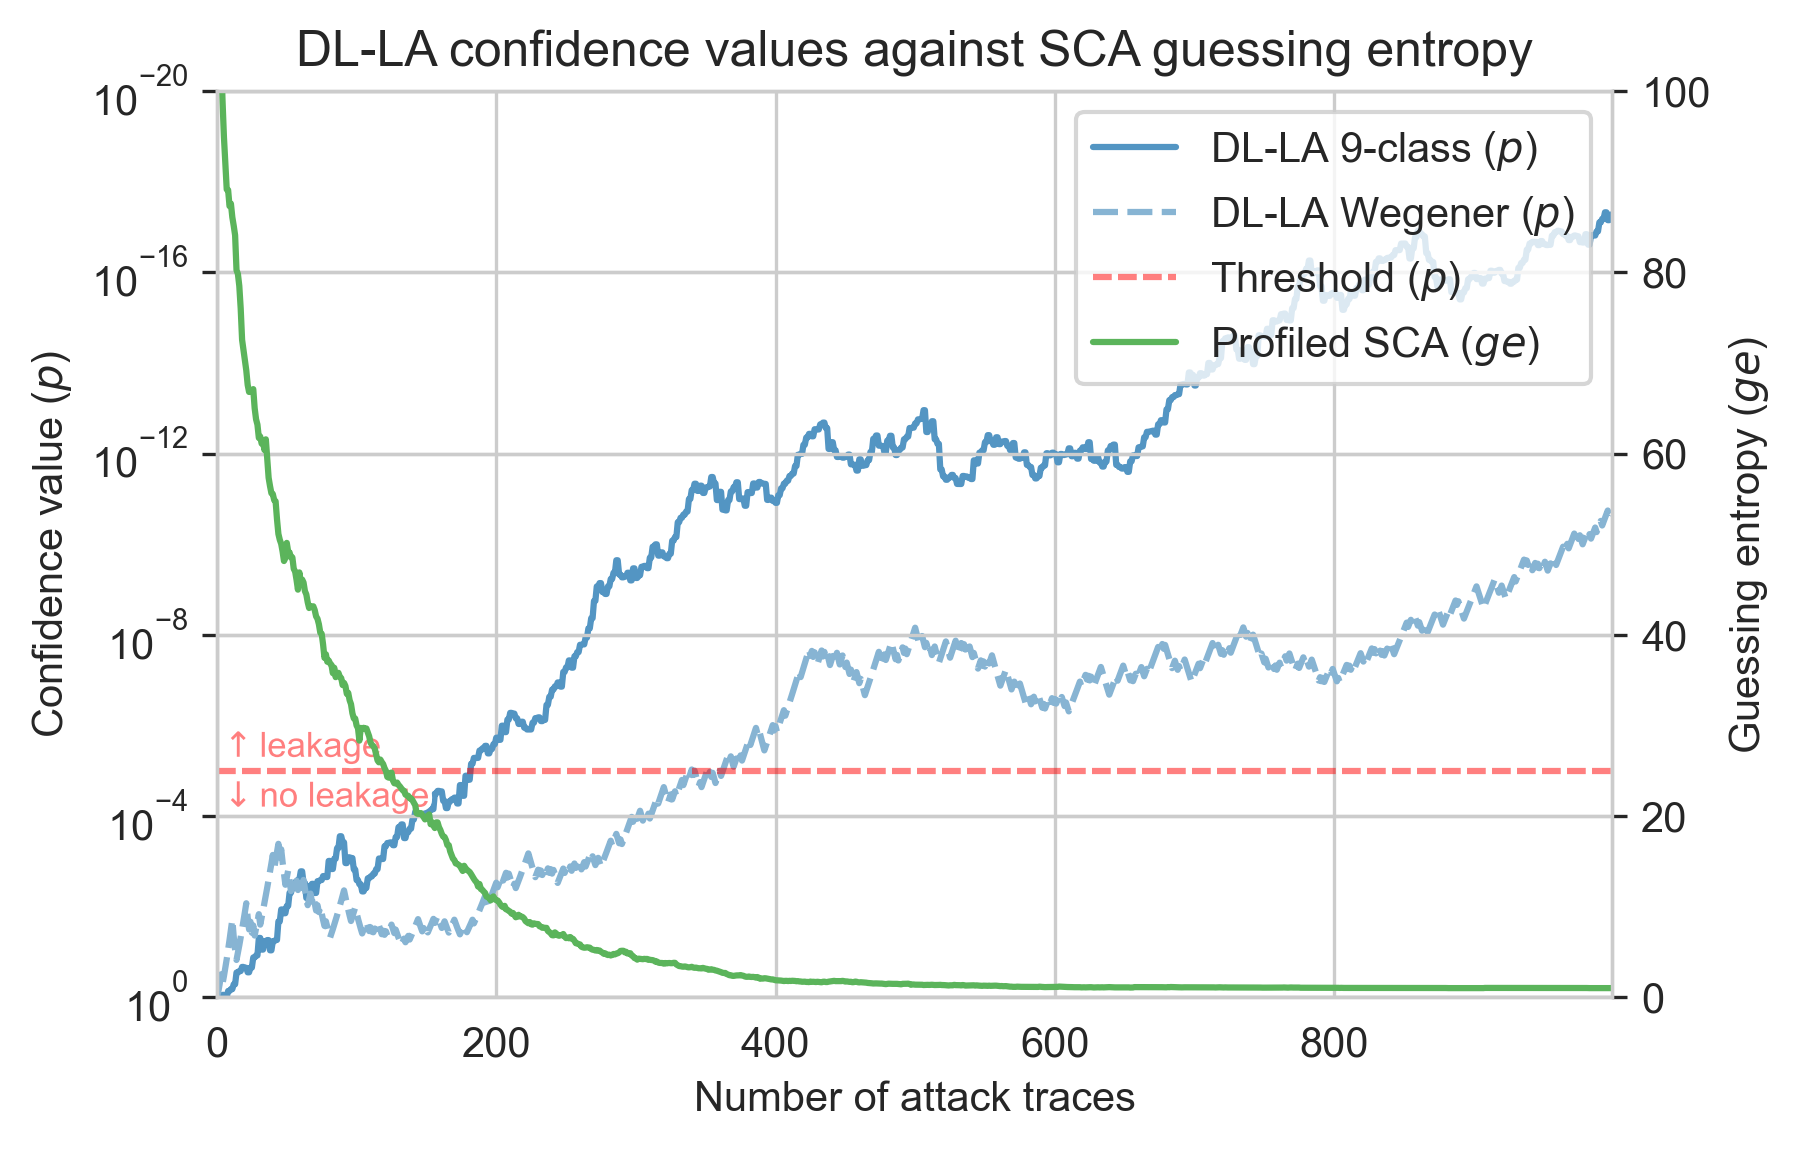

In [262]:
TITLE = "DL-LA confidence values against SCA guessing entropy"

def plot_p_value():
    df = pd.read_csv("../la/dlla-p-gradient.csv")
    df = df.drop(columns=[df.columns[0]])
    df.columns = [f"{c} ($p$)" for c in df.columns]
    num_traces = max(df.index)

    g = sns.lineplot(data=df, palette=[DLLA_PALETTE[3], DLLA_PALETTE[2]])

    p_thresh = 10 ** -5
    t_line = [p_thresh] * num_traces
    sns.lineplot(data={"Threshold ($p$)": t_line}, palette=[THRESHOLD_COLOR], dashes=[(3, 1)])

    g.set(yscale="log",
          ylabel="Confidence value ($p$)",
          xlabel="Number of attack traces",
          title=TITLE,
          ylim=(10 ** 0, 10 ** -20), xlim=(0, num_traces))
    g.yaxis.set_major_locator(FixedLocator(10. ** (-np.arange(0, 21, 4))))


    stroke = [withStroke(linewidth=2, foreground='w')]
    text(0, p_thresh * .5, '$\\uparrow$leakage', color=THRESHOLD_COLOR, size="small").set_path_effects(stroke)
    text(0, p_thresh * 1.5, '$\\downarrow$no leakage', va='top', color=THRESHOLD_COLOR, size="small").set_path_effects(stroke)

    return g

def plot_kr():
    df = pd.read_csv("../../examples/profiled-sca-ge.csv")
    df = df.drop(columns=[df.columns[0]])
    df.columns = [f"{c} ($ge$)" for c in df.columns]

    g = sns.lineplot(data=df, palette=[SCA_PALETTE[3]])
    g.set(ylim=(0,100), ylabel="Guessing entropy ($ge$)")

    return g


KR_THRESH = 10


def plot():
    g = plot_p_value()
    g.get_legend().remove()
    g2 = plt.twinx()
    plot_kr()

    handles1, labels1 = g.get_legend_handles_labels()
    handles2, labels2 = g2.get_legend_handles_labels()
    g2.legend(handles1 + handles2, labels1 + labels2, loc="upper right")

    store_sns(g, f"sca-p-ascad-traces")


plot()